
## Data satellite images



Create an account on https://openeo.dataspace.copernicus.eu/ 

The `openeo` Python package provides a Python interface to the openEO API, enabling us to process remote sensing and Earth observation data via Python.


## Requirements 

Then install the openeo package with `pip install xarray netcdf4 h5netcdf openeo` and import it `import openeo`.
  



### Information about the type of satellite

**Command**:
```python
connection.describe_collection("SENTINEL2_L2A")
```
With this command, we get all the metadata on the Sentinel-2 L2A, including the date of the first data available worldwide, the set of spectral bands, etc.

### Selecting a set of satellite images with specific criteria

**Loading data**:
The `load_collection` function allows you to load a DataCube object, which is a set of satellite data. The data added to the data cube can be restricted using the parameters `id`, `spatial_extent`, `temporal_extent`, `bands`, and `max_cloud_cover`. If no data is available for the given extents, a `NoDataAvailable` exception is raised.

- **id**:
  Limits the data to load to the type of satellite we are interested in. In our case, we choose Sentinel-2 L2A. Sentinel-2 data is classified by preprocessing level. Level-2A (atmospherically corrected surface reflectance in cartographic geometry) is processed using the Sen2Cor algorithm to produce Level-2A, which is bottom-of-atmosphere reflectance. Level-2A data is ideal for research activities as it allows for more in-depth analysis without applying additional atmospheric corrections.

- **spatial_extent**:
  Limits the data to load from the collection to the specified polygon(s). We can provide the data in JSON format, or like this:
  ```python
  spatial_extent = {"west": 6.65, "east": 6.67, "north": 45.26, "south": 45.22}
  ```

- **temporal_extent**:
  Limits the data to load from the collection to the specified closed-left time interval. Applies to all temporal dimensions. The interval must be specified as an array with exactly two elements.

- **bands**:
  Adds only the specified bands to the data cube so that bands not matching the list of band names are not available. In our case, , the bands `B04`, `B02` and `B08` are of interest.

- **max_cloud_cover**:
  Limits the data to the imposed cloud cover. This data is an estimate provided by the Copernicus interface. In my opinion, some satellite images, even filtered, seem to have a higher cloud cover than 20%. Therefore, it would be interesting to review them. We select images in the summer period.





In [3]:
import openeo
import json
import xarray
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Transformer
import rioxarray
from utils_ import alphanumeric_sort
import glob
import os


# Transformer pour convertir de Lambert 93 à WGS 84
transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326", always_xy=True)

# Définir les limites en Lambert 93
xmin, ymin = 537000, 6206000
xmax, ymax = 542000, 6211000


# Convertir les coordonnées en WGS 84
bottom_left = transformer.transform(xmin, ymin)
top_left = transformer.transform(xmin, ymax)
top_right = transformer.transform(xmax, ymax)
bottom_right = transformer.transform(xmax, ymin)

# Créer le GeoJSON avec les coordonnées converties
fields_aoi = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [bottom_left[0], bottom_left[1]],
                    [top_left[0], top_left[1]],
                    [top_right[0], top_right[1]],
                    [bottom_right[0], bottom_right[1]],
                    [bottom_left[0], bottom_left[1]]  
                ]]
            }
        }
    ]
}

# Connecter à OpenEO et authentifier
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()



Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2024-05-01", "2024-09-30"],
    spatial_extent=fields_aoi,
    bands=["B04", "B03", "B02", "B08","SCL"],
    max_cloud_cover=20
)

In [ ]:
s2cube.download("Ariege/ariege.nc")

In [20]:


#
ds = xarray.load_dataset("Ariege/ariege.nc")
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")
num_dates = data.sizes['t']


# Normalisation des données pour une plage 0-255
data_norm = (data - data.min()) / (data.max() - data.min()) * 255
data_norm = data_norm.clip(0, 255).astype(np.uint8)

output_dir ="Ariege/data/"




C:\Users\rober\anaconda3\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


C:\Users\rober\anaconda3\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


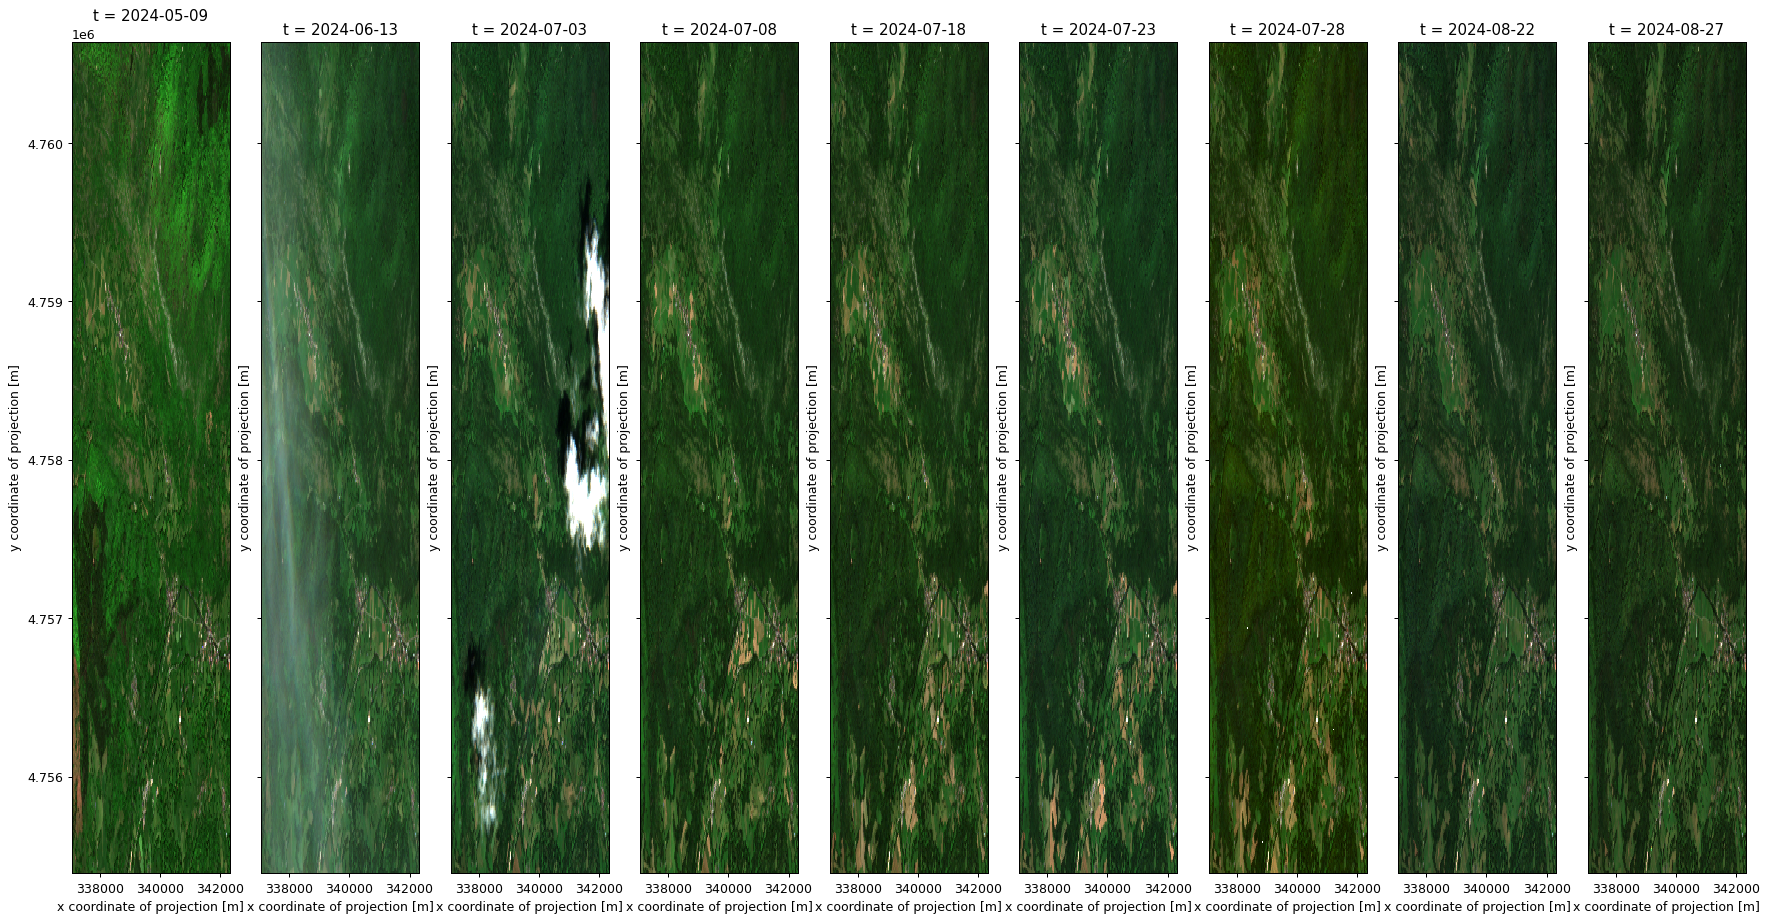

In [21]:

fig, axes = plt.subplots(ncols=num_dates, figsize=(24, 12), dpi=90, sharey=True)
if num_dates == 1:
    axes = [axes]

for i in range(num_dates):
    data[{"t": i}].plot.imshow(vmin=0, vmax=2000, ax=axes[i])


plt.show()

In [24]:

import rioxarray

image_date = str(ds['t'][7].values).replace(":", "-").replace("T", "_").split(".")[0]
output_path = output_dir + f"Ariege_norm_{image_date}.tif"

    
data_norm[{"t": 7}].rio.to_raster(output_path)



We select the 22th of August (no cloud presence)